# Маркетинговое исследование поведения пользователей мобильного приложения

## Описание проекта

Несмотря на вложения в рекламу, последние несколько месяцев компания терпит убытки.

**Задача**: разобраться в причинах, дать рекомендации по дальнейшей работе.

## Описание данных
 
Данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
 - `visits_info_short.csv`  - лог сервера с информацией о посещениях сайта, 
 - `orders_info_short.csv`  - информацию о заказах, 
 - `costs_info_short.csv`  - информация о расходах на рекламу.

Структура `visits_info_short.csv`:
 - `User Id` — уникальный идентификатор пользователя,
 - `Region` — страна пользователя,
 - `Device` — тип устройства пользователя,
 - `Channel` — идентификатор источника перехода,
 - `Session Start` — дата и время начала сессии,
 - `Session End` — дата и время окончания сессии.

Структура `orders_info_short.csv`:
 - `User Id` — уникальный идентификатор пользователя,
 - `Event Dt` — дата и время покупки,
 - `Revenue` — сумма заказа.

Структура `costs_info_short.csv`:
 - `dt` — дата проведения рекламной кампании,
 - `Channel` — идентификатор рекламного источника,
 - `costs` — расходы на эту кампанию.

## Предобработка

In [1]:
# грузим библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import missingno as msno
import re
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import cufflinks as cf

In [2]:
# загрузка файлов с данными
visits = pd.read_csv('datasets/visits_info_short.csv')
orders = pd.read_csv('datasets/orders_info_short.csv')
costs = pd.read_csv('datasets/costs_info_short.csv')

In [3]:
# посмотрим на таблицы
dataframes = [visits, orders, costs]
dataframes_names = ['visits', 'orders', 'costs']

# цикл для вывода первых строк
for df, name in zip(dataframes, dataframes_names):
    print(f"Первые строки {name}:")
    print(df.head())
    print("\n")

Первые строки visits:
        User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40  


Первые строки orders:
        User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99


Первые строки costs:
           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2

### visits

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


 - User Id — уникальный идентификатор пользователя,
 - Region — страна пользователя,
 - Device — тип устройства пользователя,
 - Channel — идентификатор источника перехода,
 - Session Start — дата и время начала сессии,
 - Session End — дата и время окончания сессии.

 > Названия столбцов приведем к snake case
 
 > Даты и время начала и окончания сессий приведем к соответствующему типу

### orders

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


 - User Id — уникальный идентификатор пользователя,
 - Event Dt — дата и время покупки,
 - Revenue — сумма заказа.

> названия приведем к snake case

> тип данных в колонке с датой и временем покупки к `datetime`

### costs

In [6]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB



 - dt — дата проведения рекламной кампании,
 - Channel — идентификатор рекламного источника,
 - costs — расходы на эту кампанию.

 > Названия столбцов приведем к snake case

 > колонку с датами проведения рекламных компаний к типу `datetime`

In [7]:
# функция для замены заглавных букв и пробелов на строчные буквы и нижние подчеркивания соответственно
def to_snake_case(column_name):
    return re.sub(r'[\s]+', '_', column_name).lower()

# цикл для приведения названий столбцов к snake_case
for df, name in zip(dataframes, dataframes_names):
    print(f"Колонки {name} до:")
    print(df.columns)    
    # приведение названий столбцов к snake_case
    df.columns = [to_snake_case(column) for column in df.columns]
    print(f"\nКолонки {name} после:")
    print(df.columns)
    print("\n")

# Печать информации о датафреймах после обновления
for df, name in zip(dataframes, dataframes_names):
    print(f"Информация о {name}:")
    print(df.info())
    print("\n")


Колонки visits до:
Index(['User Id', 'Region', 'Device', 'Channel', 'Session Start',
       'Session End'],
      dtype='object')

Колонки visits после:
Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')


Колонки orders до:
Index(['User Id', 'Event Dt', 'Revenue'], dtype='object')

Колонки orders после:
Index(['user_id', 'event_dt', 'revenue'], dtype='object')


Колонки costs до:
Index(['dt', 'Channel', 'costs'], dtype='object')

Колонки costs после:
Index(['dt', 'channel', 'costs'], dtype='object')


Информация о visits:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  

### Проверка пропусков и дубликатов 



In [8]:
# цикл для подсчета пропусков
for df, name in zip(dataframes, dataframes_names):
    print(f"Missing values for {name}:")
    missing_values = df.isnull().sum()
    print(missing_values)
    print("\n")

Missing values for visits:
user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64


Missing values for orders:
user_id     0
event_dt    0
revenue     0
dtype: int64


Missing values for costs:
dt         0
channel    0
costs      0
dtype: int64




Пропусков нет

In [9]:
# цикл для подсчета дубликатов 
for df, name in zip(dataframes, dataframes_names):
    print(f"Количество дубликатов в {name}: {df.duplicated().sum()}")
    print("\n")

Количество дубликатов в visits: 0


Количество дубликатов в orders: 0


Количество дубликатов в costs: 0




Полных дубликатов нет

Глянем уникальные значения в нечисловых столбцах для поиска неполных дубликатов

In [10]:
# выбор колонок
cols_to_check = {
    'visits': ['region', 'device', 'channel'],
    'costs': ['channel']
}

# цикл для вывода уникальных значений
for name, columns in cols_to_check.items():
    df = next(df for df, n in zip(dataframes, dataframes_names) if n == name)
    
    print(f"Названия в таблице {name}")
    
    for column in columns:
        unique_values = df[column].unique()
        print(f"{column}: {unique_values}")
    
    print("\n")


Названия в таблице visits
region: ['United States' 'UK' 'France' 'Germany']
device: ['iPhone' 'Mac' 'Android' 'PC']
channel: ['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


Названия в таблице costs
channel: ['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']




Неполные дубликаты отсутствуют

Типы данных соответствуют их значениям кроме колонок с датами и временем

### Cтолбцы с датой и временем.

In [11]:
# приведем к нужному типу
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

costs['dt'] = pd.to_datetime(costs['dt'])



In [12]:
# проверка

for df, name in zip(dataframes, dataframes_names):
    print(f"Типы в {name}:")
    print(df.dtypes)
    print("\n")

Типы в visits:
user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object


Типы в orders:
user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object


Типы в costs:
dt         datetime64[ns]
channel            object
costs             float64
dtype: object




**Вывод**

Познакомились с данными, переимновали столбцы в snake_case, проверили полные и неполные дубликаты, привели данные колонок к нужному типу.

## Импорт функций для расчёта, анализа и визуализации LTV, ROI, удержания и конверсии.


In [13]:
from def_get_profiles import get_profiles # для создания профилей пользователей
from def_get_retention import get_retention # для подсчёта Retention Rate
from def_get_conversion import get_conversion # для подсчёта конверсии
from def_get_ltv import get_ltv # для подсчёта LTV
from def_filter_data import filter_data # для сглаживания данных
from def_plot_retention import plot_retention # для построения графика Retention Rate
from def_plot_conversion import plot_conversion # для построения графика конверсии
from def_plot_ltv_roi import plot_ltv_roi # для визуализации LTV и ROI

## Исследовательский анализ данных

### Составление профилей пользователей. Определение минимальной и максимальной даты привлечения пользователей.

In [14]:
# получаем профили
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,5,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,7,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,10,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,8,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,10,False,0.230769


In [15]:
# определяем минимальную и максимальную даты привличения пользователей
print(f"Минимальная дата привлечения пользователей: {profiles['first_ts'].min()}")
print(f"Максимальная дата привлечения пользователей: {profiles['first_ts'].max()}")


Минимальная дата привлечения пользователей: 2019-05-01 00:00:41
Максимальная дата привлечения пользователей: 2019-10-27 23:59:04


Проведена проверка соответствия дат привлечения пользователей условиям проекта, как описано в техническом задании. В результате сравнения дат, полученных из данных, с предполагаемыми датами из ТЗ, убеждаемся, что они полностью соответствуют заявленным требованиям.


### Определение стран из которых пользователи приходят в приложение. На какую страну приходится больше всего платящих пользователей. 

In [16]:
# строим диаграммы
country_payment = profiles.groupby('region').agg({'user_id': 'count', 'payer': 'sum'})\
.sort_values(by='user_id', ascending=False).reset_index()

fig = sp.make_subplots(rows=1, cols=2, specs=[[{'type':'pie'}, {'type':'pie'}]], subplot_titles=['Все пользователи', 'Платящие пользователи'])

# диаграмма "все пользователи"
fig.add_trace(go.Pie(labels=country_payment['region'], values=country_payment['user_id'], textinfo='label+percent', hole=0.3),
              row=1, col=1)

# диаграмма "платящие пользователи"
fig.add_trace(go.Pie(labels=country_payment['region'], values=country_payment['payer'], textinfo='label+percent', hole=0.3),
              row=1, col=2)


fig.update_layout(title_text="Количество пользователей в разрезе стран")
fig.show()

In [17]:
# строим таблицу, отражающую количество пользователей и долю платящих из каждой страны
country_payment['percent_payment'] = country_payment.apply(lambda row: round(row['payer'] / row['user_id'] * 100, 1), axis=1)
country_payment

,region,user_id,payer,percent_payment
0,United States,100002,6902,6.9
1,UK,17575,700,4.0
2,France,17450,663,3.8
3,Germany,14981,616,4.1


**Вывод**

Пользователи из США на первом месте по общему количеству пользователей (66.7%), по количетву пользователей которые платят (77.7%), по доле платящих пользователей в разрезе стран (6.9%). Доли других стран распределены более или менее ровномерно.

### Определение устройств и их доли для платящих клиентов.


In [18]:
# группировка
device_payment = profiles.groupby('device').agg({'user_id': 'count', 'payer': 'sum'}).sort_values(by='user_id', ascending=False).reset_index()

# subplot с двумя круговыми диаграммами
fig = sp.make_subplots(rows=1, cols=2, specs=[[{'type':'pie'}, {'type':'pie'}]], subplot_titles=['Гаджеты пользователей', 'Гаджеты платящих пользователей'])

# доли устройств пользователей
fig.add_trace(go.Pie(labels=device_payment['device'], values=device_payment['user_id'], textinfo='label+percent', hole=0.3),
              row=1, col=1)

# доли устройств платящих пользователей
fig.add_trace(go.Pie(labels=device_payment['device'], values=device_payment['payer'], textinfo='label+percent', hole=0.3),
              row=1, col=2)

# Настройка макета
fig.update_layout(title_text="Доли устройств пользователей и платящих пользователей")

# Отображение диаграмм
fig.show()


In [19]:
# строим таблицу, отражающую количество пользователей и долю платящих для каждого устройства
device_payment['percent_payment'] = (device_payment['payer'] / device_payment['user_id']*100).round(1)
device_payment


,device,user_id,payer,percent_payment
0,iPhone,54479,3382,6.2
1,Android,35032,2050,5.9
2,PC,30455,1537,5.0
3,Mac,30042,1912,6.4


**Вывод**

Пользоватей айфонов больше, как в сегменте платящих (38.1%), так и всех пользователей (36.3%). 

Доли платящих для всех устройств примерно одинаковы. Разброс 5% - 6.2%

### Изучение рекламных источников привлечения и определение каналов, из которых пришло больше всего платящих пользователей.

In [20]:
# Группировка данных
channel_payment = profiles.groupby('channel').agg({'user_id': 'count', 'payer': 'sum'})\
    .sort_values(by='user_id', ascending=False).reset_index()

# Создание столбчатой диаграммы для пользователей
fig1 = px.bar(channel_payment, x='channel', y='user_id', text=(channel_payment['user_id']/channel_payment['user_id'].sum())*100,
              title='Каналы привлечения пользователей',
              labels={'user_id': 'Количество пользователей', 'channel': 'Канал'},
              color_discrete_sequence=['skyblue'])

fig1.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

# Создание столбчатой диаграммы для платящих пользователей
fig2 = px.bar(channel_payment, x='channel', y='payer', text=(channel_payment['payer']/channel_payment['payer'].sum())*100,
              title='Каналы привлечения платящих пользователей',
              labels={'payer': 'Количество платящих пользователей', 'channel': 'Канал'},
              color_discrete_sequence=['lightcoral'])

fig2.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig1.show()
fig2.show()


In [21]:
# строим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения
channel_payment['percent_payment'] = (channel_payment['payer'] / channel_payment['user_id']*100).round(1)
channel_payment = channel_payment.sort_values(by='percent_payment', ascending=False)
channel_payment

,channel,user_id,payer,percent_payment
1,FaceBoom,29144,3557,12.2
9,AdNonSense,3880,440,11.3
10,lambdaMediaAds,2149,225,10.5
2,TipTop,19561,1878,9.6
6,RocketSuperAds,4448,352,7.9
5,WahooNetBanner,8553,453,5.3
8,YRabbit,4312,165,3.8
7,MediaTornado,4364,156,3.6
4,LeapBob,8553,262,3.1
3,OppleCreativeMedia,8605,233,2.7


**Вывод**

Все пользователи:
 - Из всех пользователей приложения, значительную часть составляют "Органические" 37%. 
 - Пользователи привлеченные через каналы FaceBoom и Tiptop - 19% и 13% соответственно. 
 - Оставшиеся 30% пользователей привлечены совокупно из восьми каналов привлечения, доля каждого из которых не превышает 5,7% от общего числа пользователей.

Платящие пользователи:
 - Лидерство за пользователями, привлеченными из канала Faceboom 40%
 - Tiptop, с долей в 21%
 - "органические" составляют 13%. 
 - Оставшиеся восемь каналов суммарно составляют 26%, при этом доля каждого из них не превышает 5%.

"неплатящие" в "платящих":
 - пользователи из каналов FaceBoom, AdNonSense, LambdaMediaAds, Типтоп и RocketSuper чаще всего готовы совершать покупки, с процентом совершенных покупок в диапазоне от 8% до 12%.

## Маркетинг

### Общая сумма расходов на маркетинг

In [22]:
expenses_sum = (costs['costs'].sum()).round(1)
print('Общая сумма расходов на маркетинг:', expenses_sum)

Общая сумма расходов на маркетинг: 105497.3


### Распределение трат по рекламным источникам

In [23]:
expenses_df = profiles.groupby('channel').agg({'acquisition_cost': 'sum'}).sort_values(by='acquisition_cost', ascending=False)
expenses_df['percentage'] = ((expenses_df['acquisition_cost'] / expenses_df['acquisition_cost'].sum()) * 100).round(1)
expenses_df

,acquisition_cost,percentage
channel,,
TipTop,54751.30,51.9
FaceBoom,32445.60,30.8
WahooNetBanner,5151.00,4.9
AdNonSense,3911.25,3.7
OppleCreativeMedia,2151.25,2.0
RocketSuperAds,1833.00,1.7
LeapBob,1797.60,1.7
lambdaMediaAds,1557.60,1.5
MediaTornado,954.48,0.9


**Вывод**

Каналы привлечения TipTop и FaceBoom это 83% всего потраченого бюджета на маркетинг.

Пользователи привлеченные через канал TipTop это 51% бюджета, при этом доля платящих пользователей 9.6%

### Визуализация динамики изменения расходов по каждому источнику в разрезе месяцев и недель.

In [24]:
# строим график с разбивкой по месяцам
fig = px.line(costs, x='dt', y='costs', color='channel', line_group='channel',
              labels={'costs': 'Расходы', 'dt': 'Дата'},
              title='Изменение трат по времени',
              template='plotly_white')

fig.update_layout(xaxis=dict(title='Месяц'), yaxis=dict(title='Расходы'), height=600)
cf.go_offline()
fig.iplot()

In [25]:
# строим график с разбивкой по неделям

# вытаскиваем номер недели
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
min_date = costs['dt'].min()
costs['week'] = (costs['dt'] - min_date).dt.days // 7 + 1


# группируем данные по источнику и номеру недели
grouped_costs = costs.groupby(['channel', 'week'], as_index=False)['costs'].sum()

# график
fig = px.line(grouped_costs, x='week', y='costs', color='channel', line_group='channel',
              labels={'costs': 'Расходы', 'week': 'Неделя'},
              title='Изменение трат по времени по неделям по каждому источнику',
              template='plotly_white')

fig.update_layout(xaxis=dict(title='Неделя', dtick=1), yaxis=dict(title='Расходы'), height=600)
cf.go_offline()
fig.iplot()

**Вывод**

Как видно, на каналы FaceBoom и TipTop изначально тратилось больше, только за первую неделю было потрачено 755 и 502 соответственно. На остальные каналы, траты в разбросе от 25 до 284.

### Стоимость привлечения одного пользователя (CAC) из каждого источника.


In [26]:
mean_cost_channel = profiles.groupby('channel').agg({'acquisition_cost': 'mean'})\
.sort_values(by='acquisition_cost', ascending=False).reset_index()
mean_cost_channel

,channel,acquisition_cost
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


**Вывод**

Неудивительны и эти показатели, учитывая сколько потрачено на TipTop и FaceBoom

## Оценка окупаемости рекламы
Для анализа окупаемости зададим грризонт в 14 дней, а момент анализа 1 ноября 2019 года.

In [27]:
horizon = 14
observation_date = datetime(2019, 11, 1).date()

Органических пользователей принимаем решение исключить, поскольку рекламный бюджет на них не расходовался

In [28]:
profiles_no = profiles.query('channel != "organic"')

### Анализ окупаемости рекламы c помощью графиков LTV и ROI и  графиков динамики LTV, CAC и ROI

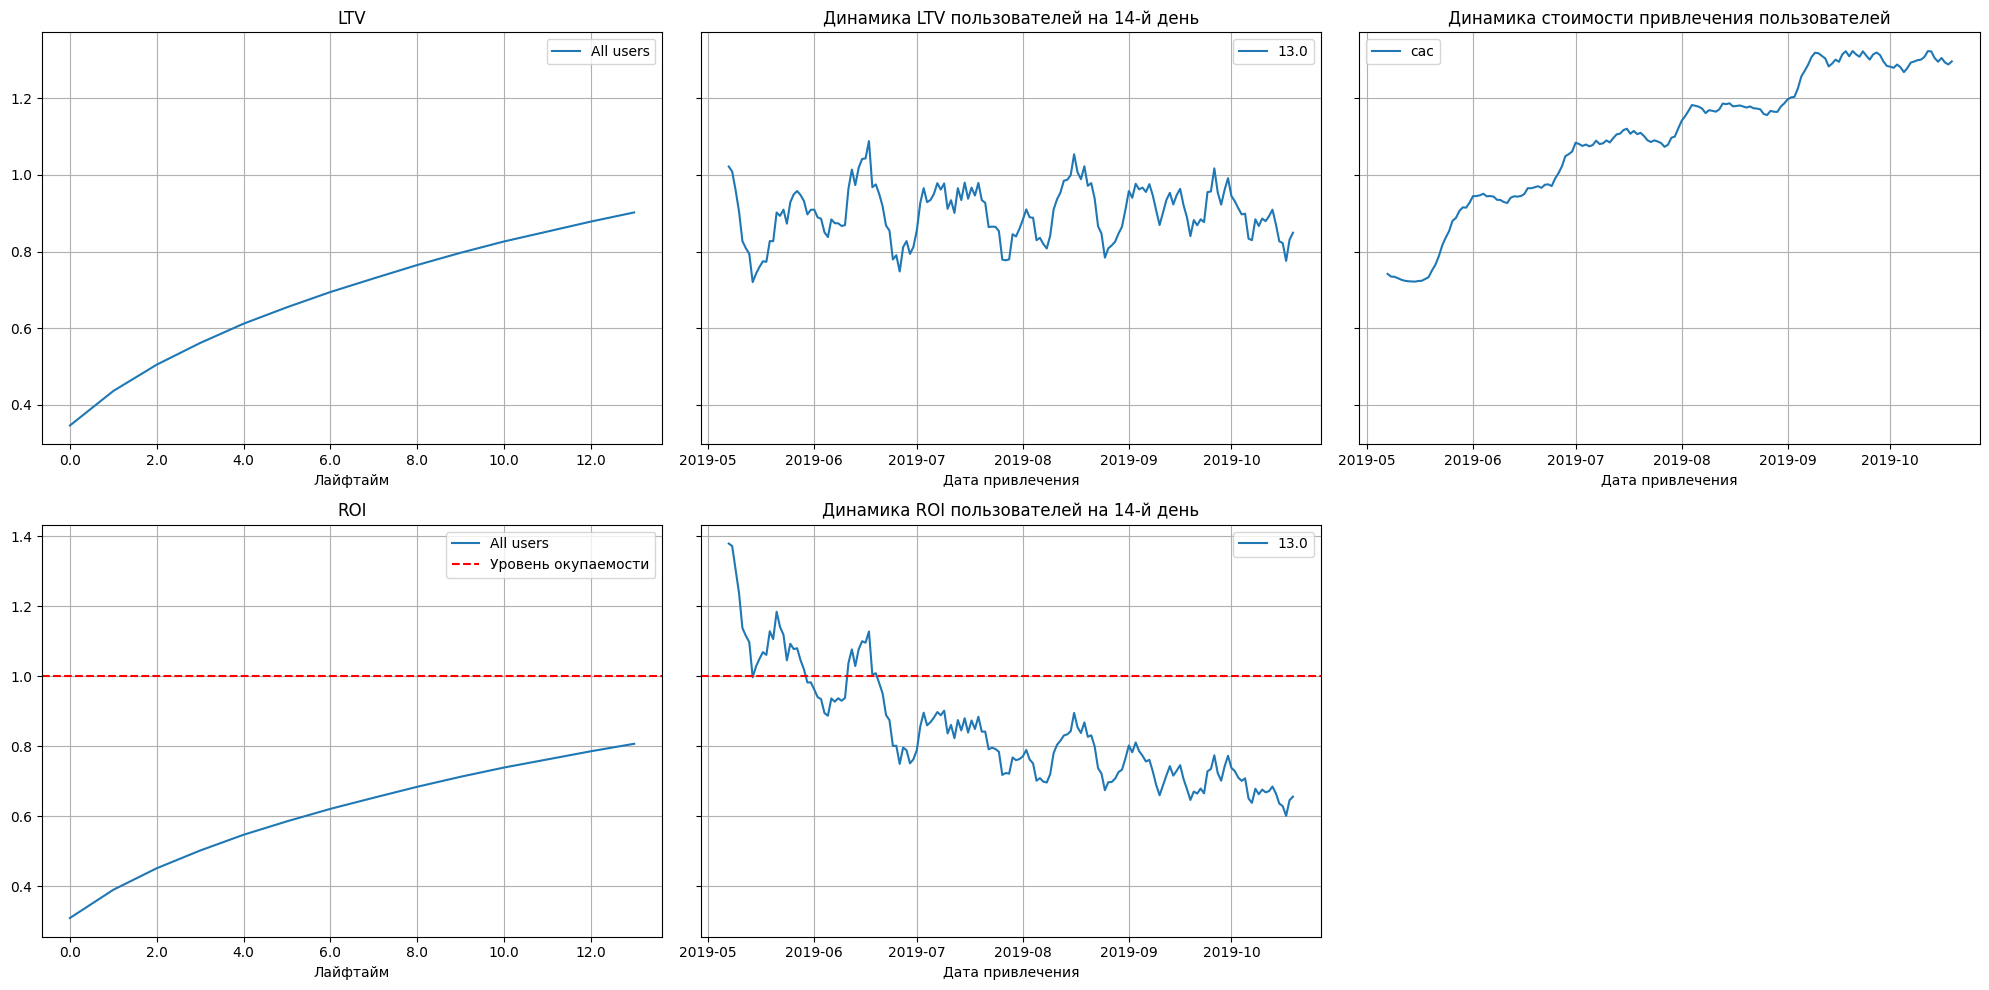

In [29]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no, orders, observation_date, horizon
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon) 

**Вывод**

1. Стабильный рост LTV:

  > LTV (пожизненная стоимость клиента) продолжает уверенно увеличиваться, что говорит о том, что прибыль с каждого клиента постепенно возрастает на протяжении всего периода использования продукта.
2. Снижение окупаемости пользователей:

  > Однако, на других графиках отмечается тревожная тенденция. К концу второй недели окупаемость пользователей снижается и достигает всего 80%.
3. Стабильный рост САС:

  > Показатель стоимости привлечения клиента (САС) стабильно увеличивается на протяжении всего рассматриваемого периода.
4. Убывающий ROI:

  > В то время как стоимость привлечения растет, показатель возврата на инвестиции (ROI) стабильно снижается, что может сигнализировать о неэффективности текущих маркетинговых стратегий.
Проблемы с окупаемостью с июня:

Заметно, что с июня месяца привлеченные пользователи перестали окупаться, что требует более детального исследования и, возможно, корректировки стратегии привлечения клиентов.

### Конверсия пользователей, их удержание и динамика изменения этих показателей. 

Здесь смотрим как органических пользователей и привлеченных рекламой

#### Конверсия

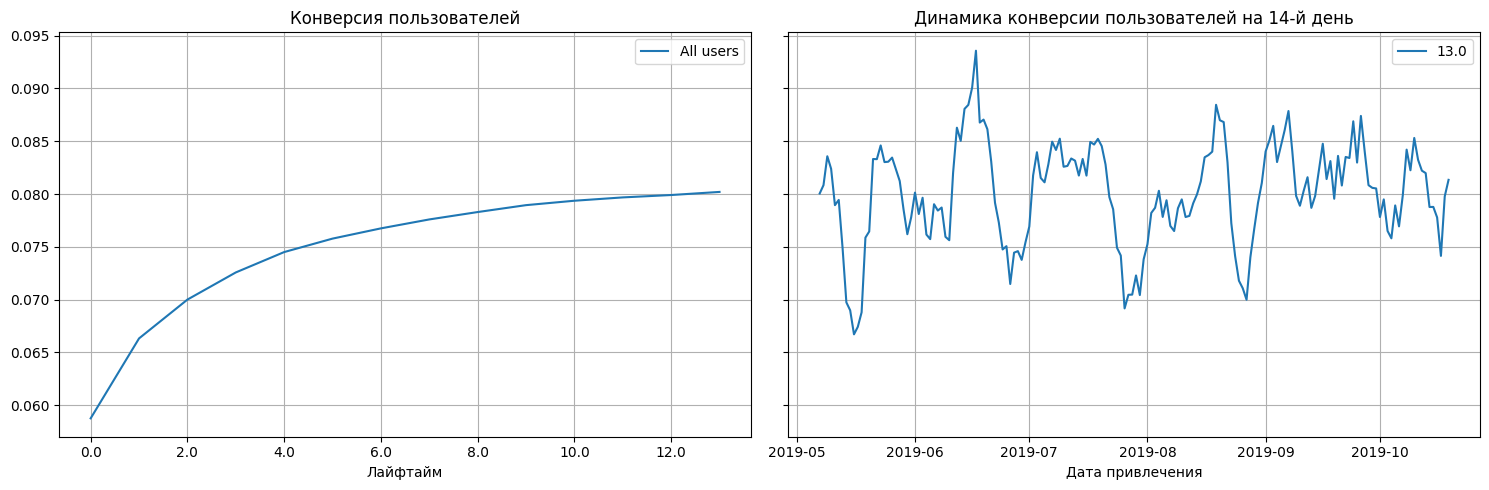

In [30]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles_no, orders, observation_date, horizon)
plot_conversion(conversion_grouped, conversion_history, horizon)

#### Удержание

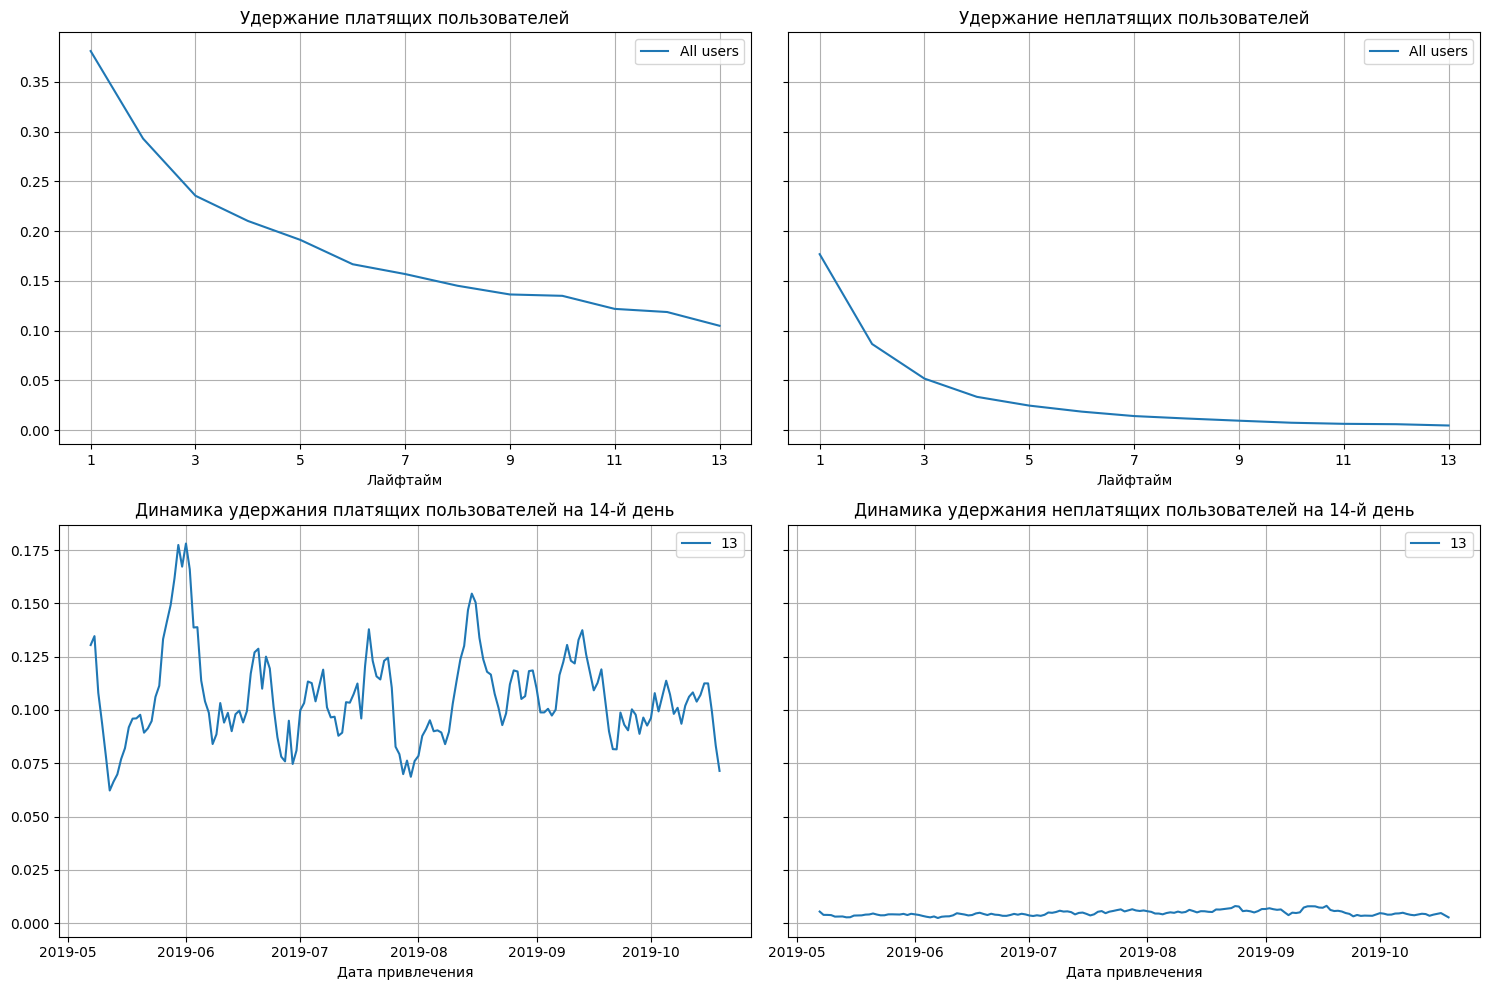

In [31]:
retention_raw, retention_grouped, retention_history = get_retention(profiles_no, visits, observation_date, horizon)

plot_retention(retention_grouped, retention_history, horizon)

**Выводы**

**Конверсия**

1. Неплохая конверсия в первые 4 дня:

  - В начале периода пользователи демонстрируют неплохую конверсию, что может свидетельствовать о эффективности мероприятий, направленных на удержание в первые дни использования продукта.
2. Умеренный рост конверсии после 4-го дня:

  - После четвёртого дня "жизни" пользователей отмечается умеренный, но все же положительный рост конверсии. Это может свидетельствовать о продолжающемся интересе пользователей, однако темпы роста становятся менее значительными.
3. Неоднородность темпов роста:

  - Следует отметить, что хотя конверсия продолжает расти после начального периода, темпы этого роста не так высоки, как в начале "жизни" продукта для пользователей.
  - 
**Удержание**

1. Низкое удержание платящих пользователей в первый день:

 - Удержание платящих пользователей в начале их "жизни" оценивается менее чем на 40%, что может быть сигналом о сложностях в создании мгновенной ценности для новых пользователей.
2. Резкое снижение к концу второй недели:

 - За две недели уровень удержания существенно снижается и составляет всего 10%, что подчеркивает проблемы долгосрочной удержания платящих клиентов.
3. Стабильное низкое удержание на протяжении двух недель:

 - Анализ динамики удержания показывает, что в течение двух недель после привлечения пользователей уровень удержания остается в диапазоне от 7% до 12%, указывая на неустойчивость стратегии удержания.
4. Максимальное удержание в июне:

 - В июне наблюдалось максимальное удержание на 14-й день — 17%, что может предостеречь от возможных положительных изменений или моментов успеха в привлечении и удержании.
Недолгое пребывание неплатящих пользователей:

Важно отметить, что неплатящие пользователи в целом не задерживаются продолжительное время, что может потребовать дополнительного изучения и оптимизации стратегий удержания для этой категории пользователей.

### Анализ окупаемости рекламы с разбивкой по устройствам.

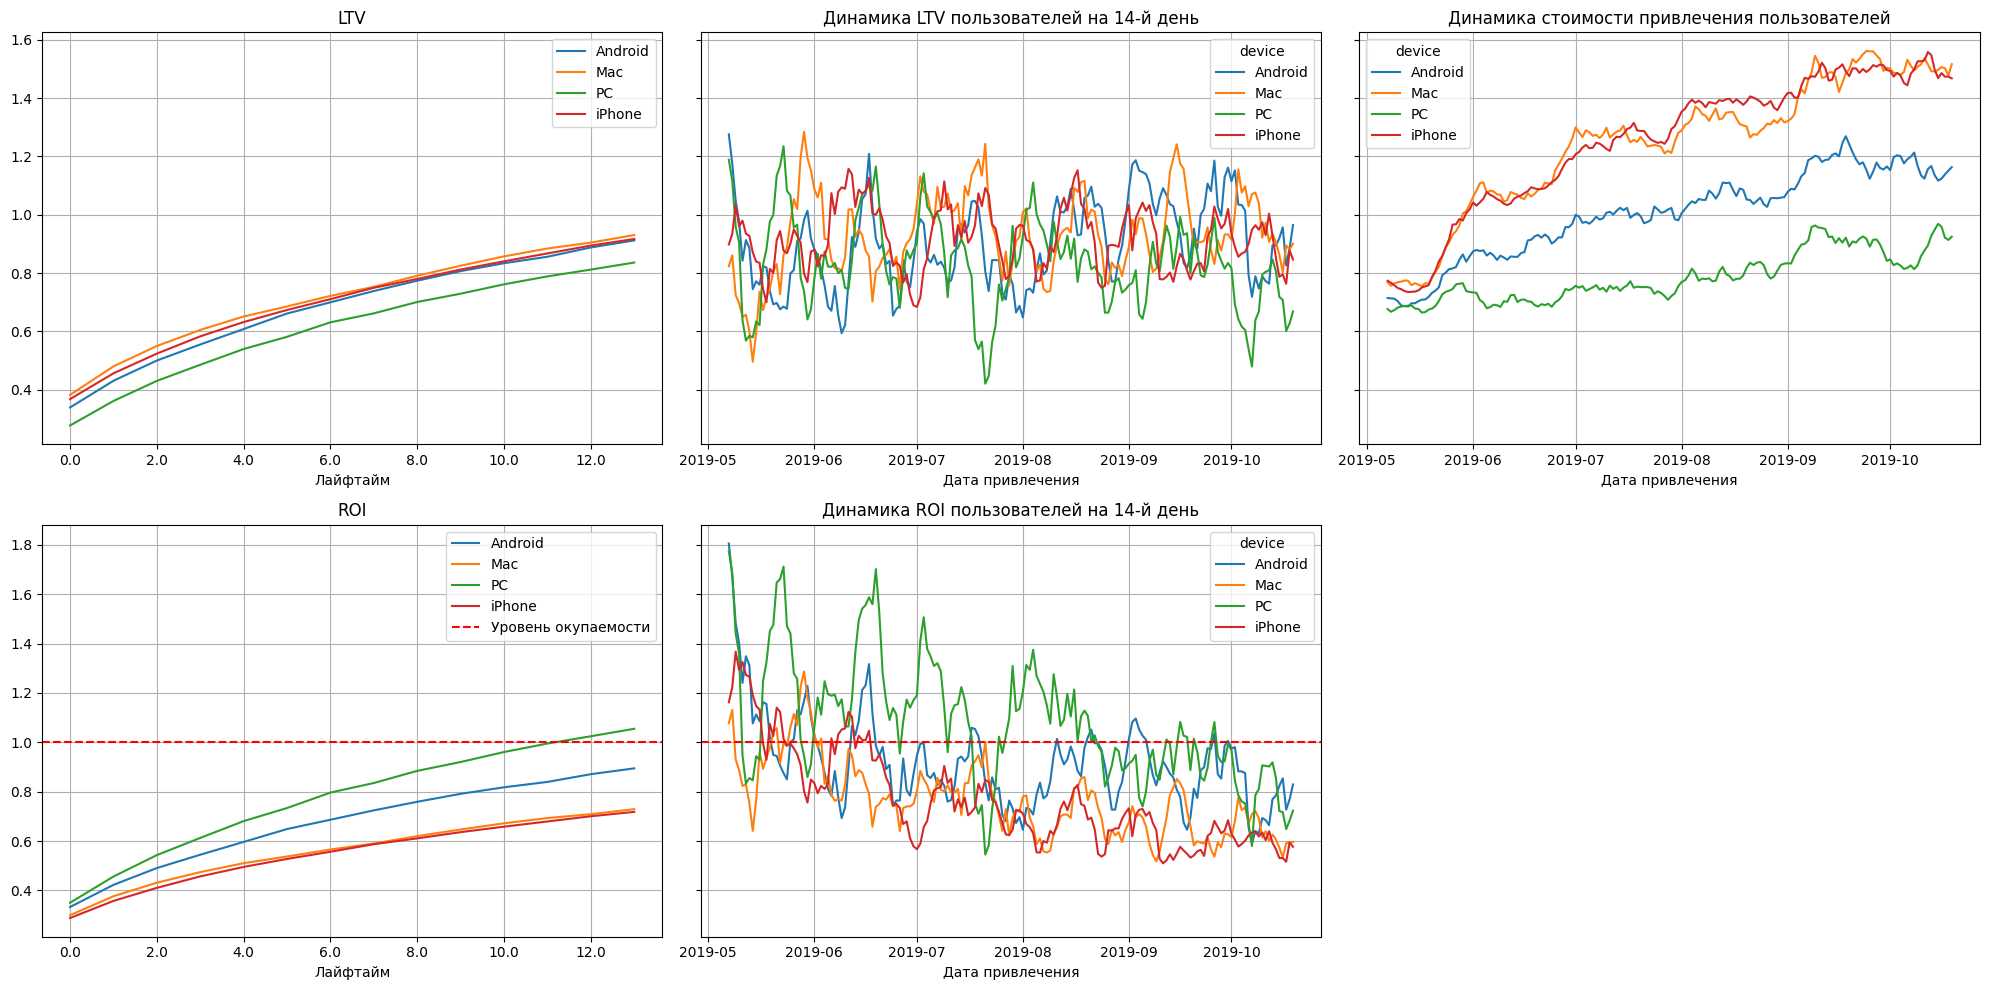

In [32]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no, orders, observation_date, horizon, dimensions=['device'])
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon, window=7)

**Вывод**
1. Стабильный рост LTV для всех устройств:

 - Общий вывод основан на том, что показатель пожизненной стоимости клиента (LTV) постоянно увеличивается для пользователей всех типов устройств.
2. Ниже LTV для держателей ПК, но с положительной окупаемостью:

 - Замечено, что LTV для держателей ПК ниже по сравнению с пользователями других устройств. Тем не менее, стоит отметить, что именно эта категория пользователей окупается, что может указывать на эффективность стратегий удержания.
3. Высокие затраты на привлечение держателей Айфона и МАКа:

 - С течением времени становится очевидным, что затраты на привлечение держателей Айфона и МАКа существенно превышают затраты на привлечение пользователей с Андроида и ПК.
4. Динамика ROI:

 - Анализ динамики возврата на инвестиции (ROI) выявляет, что в мае-июне месяце окупались практически все категории пользователей, однако после этого ROI начал снижаться.Наиболее стремительное снижение отмечено у пользователей с Айфон, в то время как пользователи с ПК оставались окупаемыми на протяжении более длительного периода.
5. Отрицательная окупаемость в сентябре-октябре:

 - Замечено, что в сентябре-октябре окупаемость ушла в минус для пользователей всех устройств, что может служить сигналом для переосмысления стратегий маркетинга и удержания клиентов в данном временном интервале.
 - 
### Анализ окупаемости рекламы с разбивкой по странам.

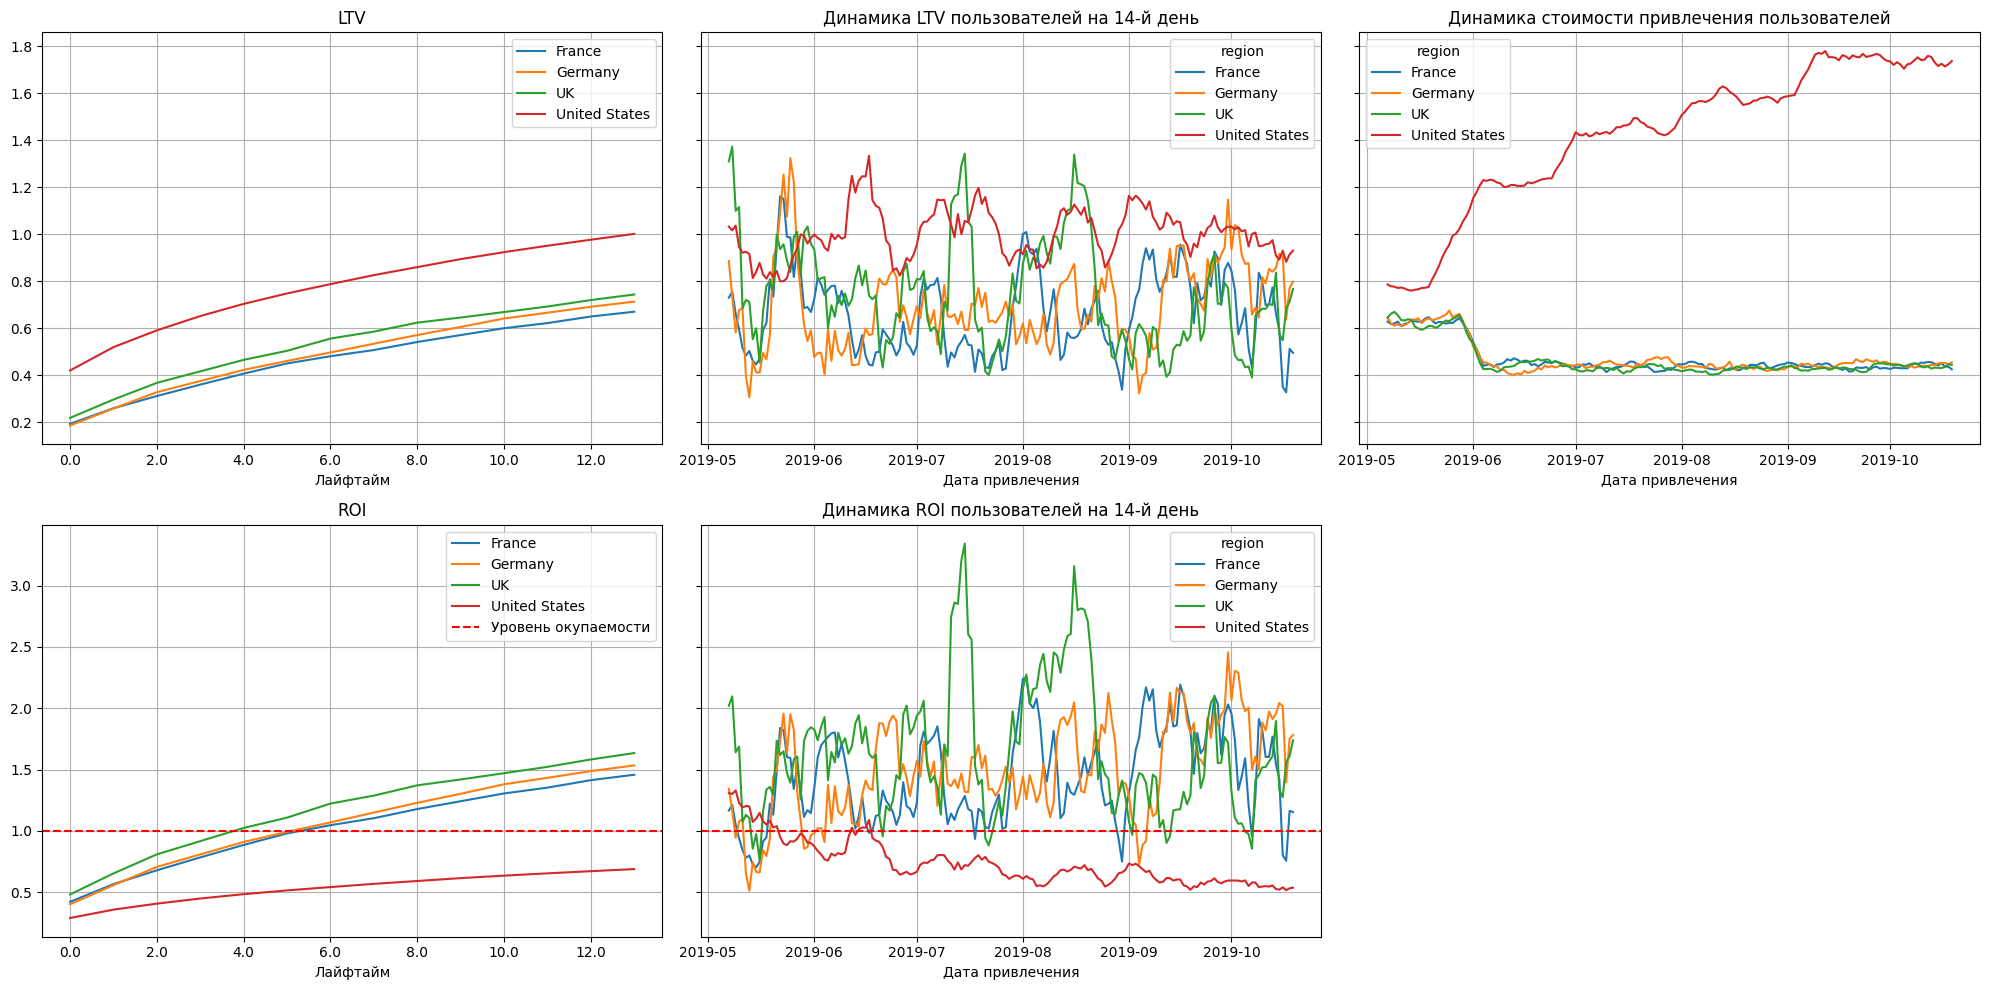

In [33]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no, orders, observation_date, horizon, dimensions=['region'])
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon, window=7) 

**Вывод**
1. Снижение окупаемости пользователей из США с начала июня:

 - Начиная с июня, пользователи из США перестали окупаться, что выглядит весьма неожиданным, учитывая, что затраты на их привлечение значительно выше по сравнению с другими странами. Это поведение может быть обусловлено наличием специфических факторов, влияющих на поведение американских пользователей после их привлечения.
2. Успешная окупаемость во Франции, Германии и Великобритании:

 - В контрасте с этим, пользователи из Франции, Германии и Великобритании демонстрируют преимущественно положительную окупаемость. Это может свидетельствовать о более успешной адаптации пользователей из этих стран к продукту, возможно, из-за более высокой ценности, которую они видят в продукте, или наличия других факторов, способствующих их активности и удержанию.

 > Необходимость выявления факторов влияния:
  > - С учетом вышеописанных различий в окупаемости между странами, целесообразно провести дополнительный анализ, направленный на выявление конкретных факторов, влияющих на поведение пользователей из США и обеспечивающих успешную окупаемость в странах Европы.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам.

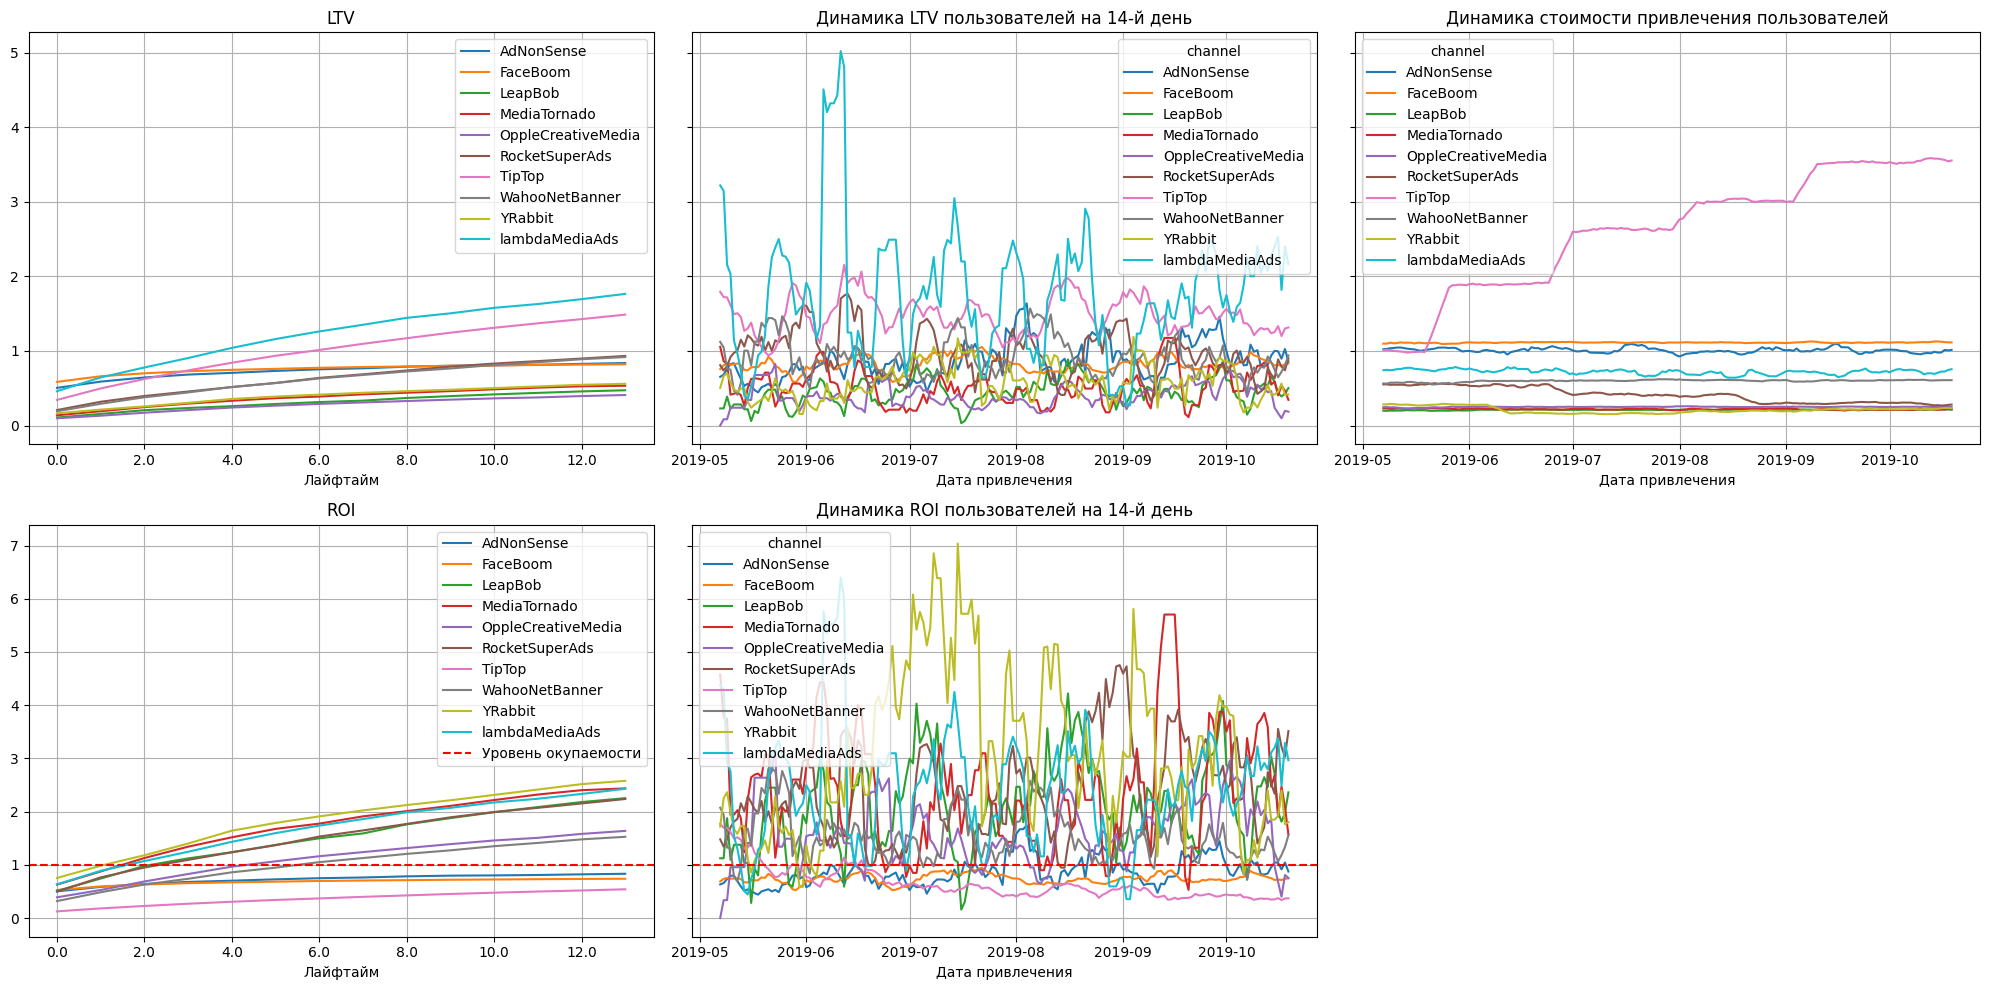

In [34]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no,orders, observation_date, horizon, dimensions=['channel'])
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon, window=7) 

Конверсия пользователей в разрезе рекламных источников

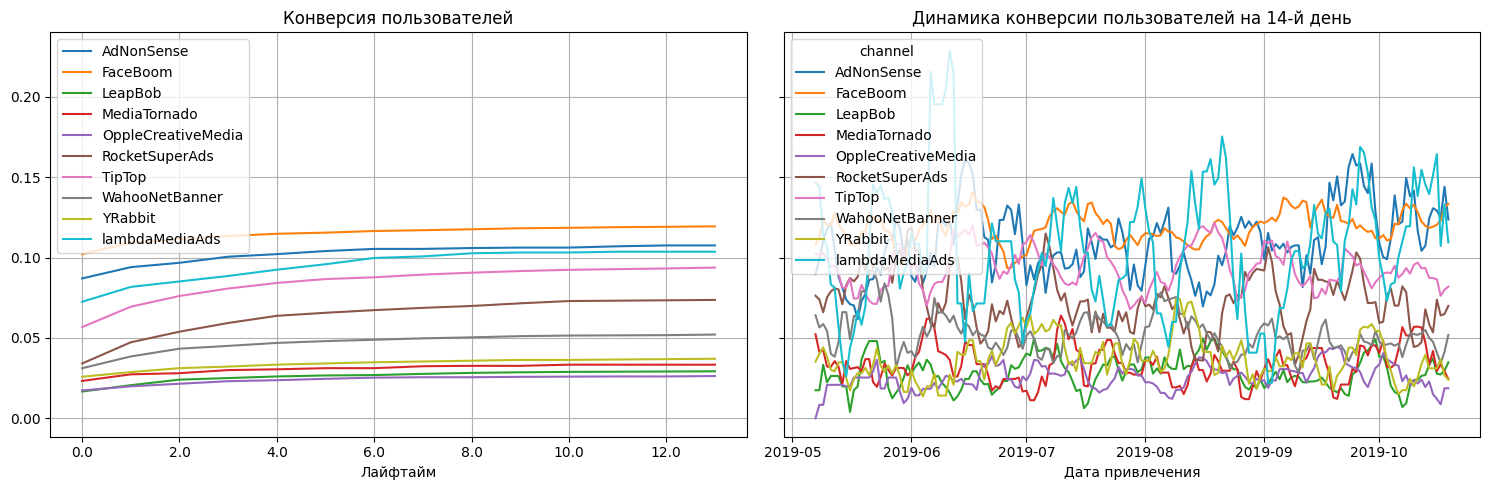

In [35]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no, orders, observation_date, horizon, dimensions=['channel'])
plot_conversion(conversion_grouped, conversion_history, horizon, window=7)

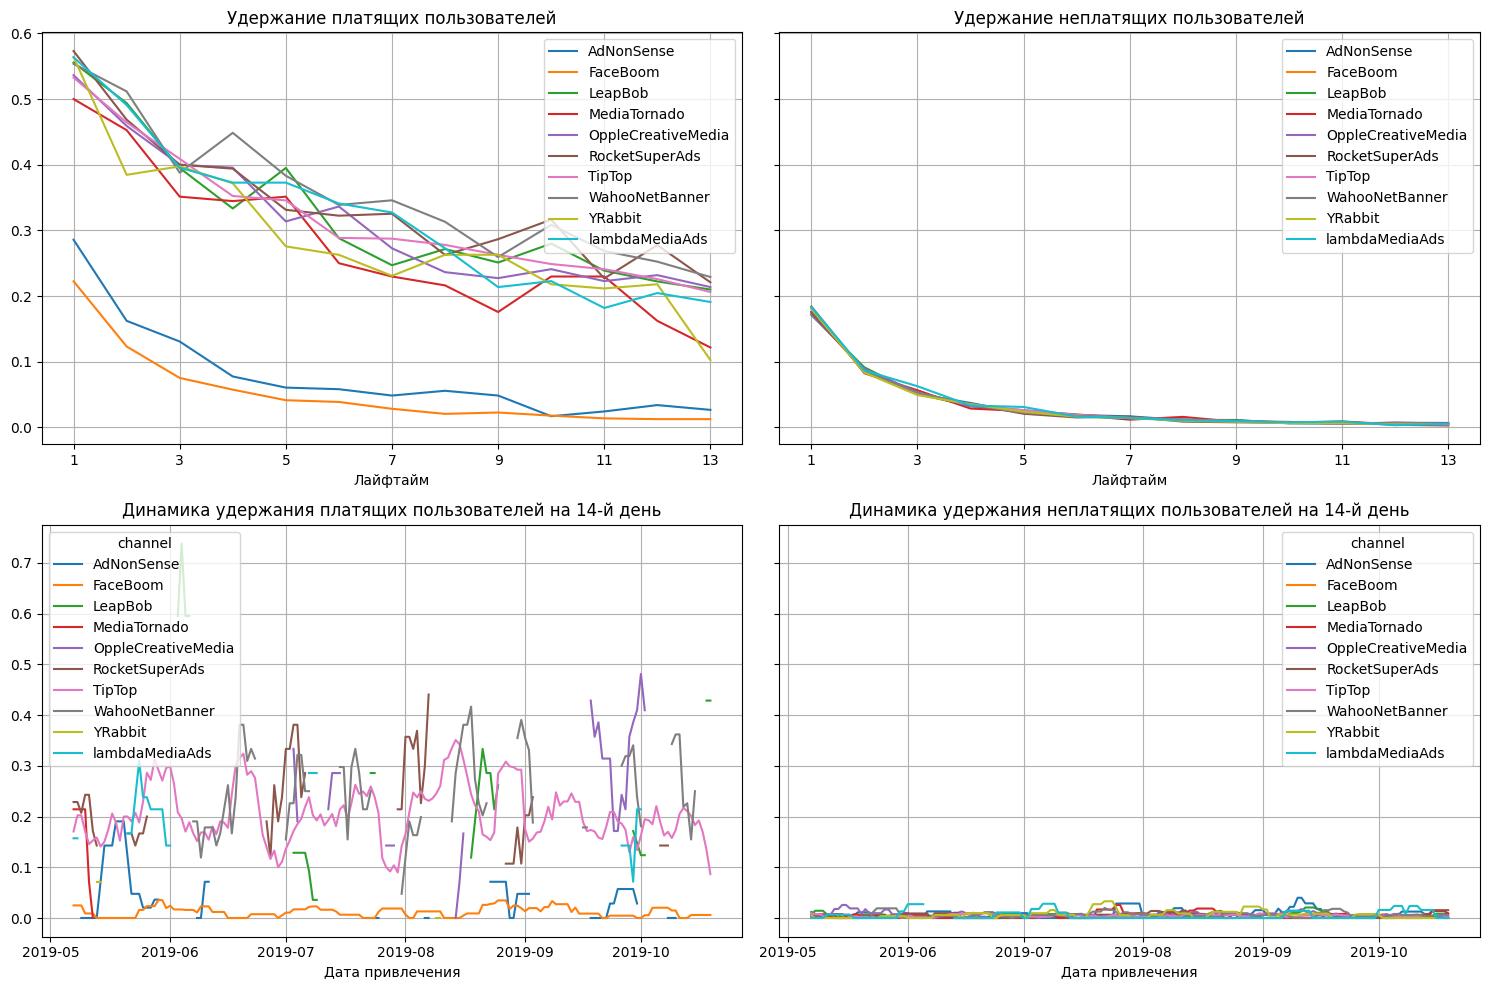

In [36]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no, visits, observation_date, horizon, dimensions=['channel'])
plot_retention(retention_grouped, retention_history, horizon)

**Вывод**
1. Общая динамика LTV:

 - Независимо от канала привлечения, LTV у всех пользователей демонстрирует положительную динамику.
2. Эффективность каналов lambdaMediaAds и TipTop:

 - Пользователи, привлеченные через каналы lambdaMediaAds и TipTop, показывают наибольшую ценность в плане LTV. Однако, уровень САС у пользователей с TipTop влияет на общую окупаемость.
3. Проблемы с окупаемостью от TipTop:

 - Высокий САС у пользователей с TipTop приводит к отсутствию окупаемости, что отражено на графике ROI, выделяя данную категорию пользователей в качестве аутсайдера в плане возврата на инвестиции.
4. Высокая рентабельность каналов YRabbit, lambdaMediaAds, MediaTornado:

 - Каналы YRabbit, lambdaMediaAds и MediaTornado привлекают внимание своей высокой окупаемостью, что делает их потенциально перспективными для дополнительных инвестиций.
5. Большинство каналов окупается, но с разной степенью эффективности:

 - Множество каналов привлечения окупается, однако уровень окупаемости варьируется в зависимости от объема затрат.
6. Проблемы с окупаемостью TipTop и FaceBoom:

 - Каналы TipTop и FaceBoom, привлекшие наибольшие затраты (82.7% от общих средств), стабильно не окупаются в соответствии с динамикой ROI.

 > Рекомендации по каналам для внимания:
 > - На основе высокой рентабельности, каналы YRabbit, lambdaMediaAds и MediaTornado представляют интерес для дополнительных инвестиций и роста эффективности.

___
 - Окупается ли реклама, направленная на привлечение пользователей в целом?
   - Общая динамика LTV демонстрирует положительный тренд, и большинство каналов привлечения окупаются. Однако, имеются проблемные каналы, такие как TipTop и FaceBoom, которые стабильно не окупаются.
 - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
   - Пользователи из США перестали окупаться, несмотря на высокие затраты на их привлечение. Кроме того, каналы TipTop и FaceBoom, на которые тратится значительное количество средств, не окупаются. Это может свидетельствовать о негативном влиянии данных стран, устройств и рекламных каналов на общую окупаемость.
 - Чем могут быть вызваны проблемы окупаемости?
   - Проблемы окупаемости могут быть вызваны высокими затратами на привлечение в неперспективные каналы, неэффективной стратегией удержания пользователей, а также возможными специфическими факторами, влияющими на поведение пользователей после привлечения.
 - Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.
   - Окупаемость рекламы зависит от выбора каналов привлечения. Стоит перераспределить ресурсы с менее эффективных каналов, таких как TipTop и FaceBoom, на более успешные, например, YRabbit, lambdaMediaAds и MediaTornado.
   - Негативное влияние пользователей из США и проблемы окупаемости каналов TipTop и FaceBoom требуют дополнительного анализа. Возможно, необходимо пересмотреть маркетинговые стратегии для американского рынка и переоценить эффективность выбранных рекламных каналов.
   - Применение инструментов аналитики и отслеживание метрик по каждому каналу помогут выявить и решить проблемы окупаемости. Регулярный мониторинг и адаптация стратегий могут улучшить результативность рекламных кампаний.



## Выводы по исследованию


### Причины неэффективности привлечения пользователей.

 - Проблемы с рекламными каналами
 - Отсутствие окупаемости от пользователей из США
 - Неэффективные стратегии удержания
 - Неоптимальное распределение ресурсов

### Рекомендации для отдела маркетинга.

1. **Оценка эффективных каналов**:

 - Рекомендуется обратить внимание на успешные каналы привлечения, такие как YRabbit, lambdaMediaAds и MediaTornado, которые проявляют высокую рентабельность.
2. **Перераспределение ресурсов**:

 - Рассмотреть возможность перераспределения средств, предварительно направленных на каналы TipTop и FaceBoom, в пользу более эффективных и перспективных платформ с целью улучшения общей окупаемости.
 - Канал FaceBoom - yизкий уровень удержания пользователей. Это важный сигнал, который требует внимания и дальнейших действий, рекомендация, провести дополнительный анализ по поиску причин низких показателей либо сотрудничество с данным каналом остановить
3. **Анализ пользователей из США**:

 - Проведение дополнительного анализа поведения пользователей из США может предоставить ценную информацию о факторах, влияющих на их окупаемость, что может послужить основой для адаптации маркетинговых стратегий.
4. **Оптимизация стратегий удержания**:

 - Взгляд на стратегии удержания пользователей после привлечения может привести к улучшению лояльности и увеличению продолжительности взаимодействия с продуктом.
5. **Динамическое управление кампаниями**:

 - Внедрение системы динамического управления кампаниями в зависимости от изменяющихся условий окупаемости позволит оперативно реагировать на изменения в эффективности каналов.
6. **Мониторинг ROI**:

 - Регулярное отслеживание ROI для каждого канала привлечения предоставит оперативную информацию об эффективности, что способствует более эффективному распределению ресурсов.